In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import dask
from dask.diagnostics import ProgressBar

import warnings, os

# Load saved results

In [2]:
def preprocess(ds):
    ds = ds.rename({'Duration':'duration','Gamma':'gamma','Tp':'tp','Seed':'seed'})
    ds = ds.assign_coords({'duration':ds['duration'],'gamma':ds['gamma'],'tp':ds['tp'],'seed':range(len(ds['seed']))})
    return ds
    
fn = 'data/timeseries_stats/RAS_n10000_2Hz_fixedres.zarr'
ds = preprocess(xr.open_zarr(fn))

ds['TzTp'] = ds['Tz']/ds['tp']
ds['HmHs'] = ds['Hmax']/ds['Hs']

ds = ds.stack(N=['duration','tp'])
ds['N'] = ds['duration']/ds['tp']

ds = ds.sortby('N')
ds = ds.set_index({'N':'N'})
ds = ds.set_coords('N')

ds = ds.load()
# ds
ds_std = ds.std(dim='seed')
ds_mean = ds.mean(dim='seed')
ds_max = ds.max(dim='seed')
ds_CV = ds_std/ds_mean
ds_CV = ds_CV.drop('this_seed')
ds_CV = ds_CV.load()

labels={'Hs':'$H_s$','Hmax':'$H_{max}$','HmHs':'$H_{max}/H_s$','r':'r'}

# Look at averaged statistics

In [ ]:
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')

In [ ]:
layout=[]
for v in ds_mean.data_vars:
    p=ds_mean[v].hvplot.scatter(x='N',by='gamma',width=350,height=450).opts(logx=True, logy=True)
    layout.append(p)
layout = hv.Layout(layout).cols(3)
display(layout)

In [ ]:
layout=[]
for v in ds_std.data_vars:
    p=ds_std[v].hvplot.scatter(x='N',by='gamma',width=350,height=450).opts(logx=True,logy=True)
    layout.append(p)
layout = hv.Layout(layout).cols(3)
display(layout)

In [ ]:
layout=[]
for v in ds_CV.data_vars:
    p=ds_CV[v].hvplot.scatter(x='N',by='gamma',width=350,height=450).opts(logx=True, logy=True)
    layout.append(p)
layout = hv.Layout(layout).cols(3)
display(layout)

# Examine normality of data

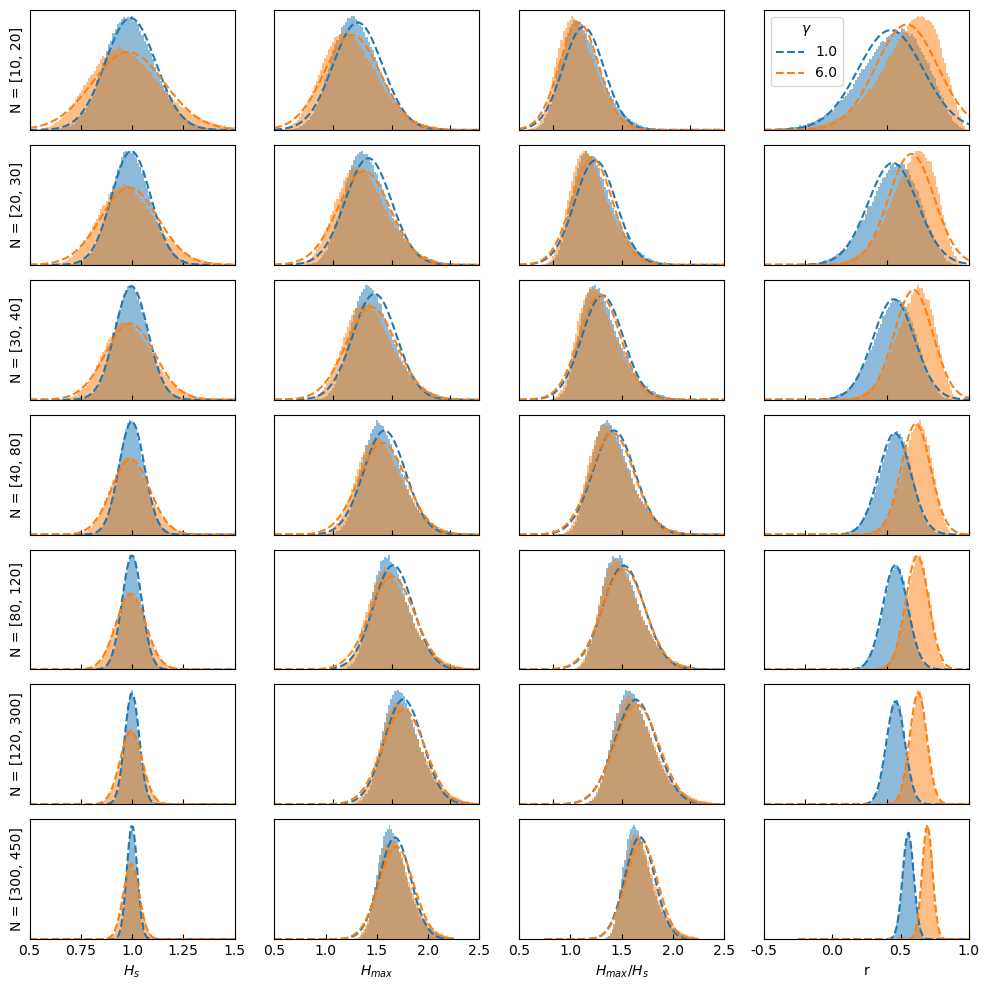

In [3]:
vv={'Hs':(0.5,1.5),'Hmax':(0.5,2.25),'HmHs':(0.75,2.25),'r':(-0.25,1)}

nn=[slice(10,20),slice(20,30),slice(30,40),slice(40,80),slice(80,120),slice(120,300),slice(300,450)]

fig,axs = plt.subplots(len(nn),len(vv),figsize=(10,10))

colors=sns.color_palette().as_hex()

for j,v in enumerate(vv.keys()):
    for i,n in enumerate(nn):
        ax = axs[i,j]
        bins=np.linspace(*vv[v],num=100)

        sample1 = ds.sel(gamma=1).sel(N=n).stack(sample=['N','seed'])[v]
        sns.histplot(sample1,ax = ax,stat='density',element='bars',edgecolor=None,bins=bins,color=colors[0],alpha=0.5)
        ncoeffs = ss.norm.fit(sample1)
        nfitted = ss.norm.pdf(bins,*ncoeffs)
        ax.plot(bins,nfitted,ls='--',lw=1.5,color=colors[0],label=1.0)

        sample2 = ds.sel(gamma=6).sel(N=n).stack(sample=['N','seed'])[v]
        sns.histplot(sample2,ax = ax,stat='density',element='bars',edgecolor=None,bins=bins,color=colors[1],alpha=0.5)
        ncoeffs = ss.norm.fit(sample2)
        nfitted = ss.norm.pdf(bins,*ncoeffs)
        ax.plot(bins,nfitted,ls='--',lw=1.5,color=colors[1],label=6.0)

        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim(vv[v])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.tick_params(which='both',direction='in')

        if j == 0:
            ax.set_ylabel(f'N = [{n.start}, {n.stop}]')
            
        if i == len(nn)-1:
            ticks = ax.get_xticks()
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticks)
            ax.set_xlabel(f'{labels[v]}')

        if (i==0) & (j==3):
            lax=ax.legend(loc='upper left')
            lax.set_title('$\gamma$')

fig.tight_layout()
fig.savefig('figures/DistributionNormality.png',bbox_inches='tight')

# Unconstrained fits... fails a bit

In [ ]:
def fit_dist(sample,dist):
    coeffs = dist.fit(sample)
    return np.array(coeffs)

In [ ]:
distn={'Hs':gamma,'Hmax':weibull_max,'HmHs':weibull_max}
ds_chunked = ds.chunk({'gamma':-1,'N':1,'seed':-1})

fits = xr.Dataset()
for v,dist in distn.items():
    fits[v] = xr.apply_ufunc(fit_dist,
                            ds_chunked[v],
                            dist,
                            input_core_dims=[['seed'],[]],
                            output_core_dims=[['coeffs']],
                            vectorize=True,
                            dask='parallelized',
                            output_dtypes=['float'],
                            dask_gufunc_kwargs=dict(output_sizes=dict(coeffs=3))
                            )
fits

In [ ]:
with dask.config.set(scheduler='processes'):
    with ProgressBar():
        fits = fits.compute()

In [ ]:
limits=[30,5,5]
layout = []
for c in range(len(fits.coeffs)):
    for v in ['Hmax','HmHs']:
        data = fits[v].isel(coeffs=c)
        data = data.where(data<limits[c])
        p=data.hvplot.scatter(x='N',by='gamma',alpha=0.75,line_color=None,width=400,height=300).opts(logx=True,logy=True)
        layout.append(p)
layout=hv.Layout(layout).cols(2)
display(layout)

In [ ]:
limits=[1000,5,5]
layout = []
for c in range(len(fits.coeffs)):
    for v in ['Hs']:
        data = fits[v].isel(coeffs=c)
        data = data.where(data<limits[c])
        p=data.hvplot.scatter(x='N',by='gamma',alpha=0.75,line_color=None,width=400,height=300).opts(logx=True,logy=True)
        layout.append(p)
layout=hv.Layout(layout).cols(1)
display(layout)

# Examine the effects of constraining the fits by expected variations with N

In [ ]:
from scipy.stats import fit
v='Hs'
N=10.
subset=ds[v].sel(gamma=1.0)
sample1 = subset.sel(N=N)

bounds = [(N,N),(1E-5,1),(1E-4,1)]
fr = fit(gamma,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()

subset=ds[v].sel(gamma=6.5)
sample1 = subset.sel(N=N)

bounds = [(N,N),(1E-5,1),(1E-4,1)]
fr = fit(gamma,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()

In [ ]:
v='HmHs'
N=10.
subset=ds[v].sel(gamma=6.5)
sample1 = subset.sel(N=N)
Nm=N

bounds = [(3,20),(0.1,8),(np.sqrt(np.log(Nm/2)),np.sqrt(np.log(Nm/2)))]
fr = fit(weibull_max,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()

subset=ds[v].sel(gamma=1.0)
sample1 = subset.sel(N=N)
Nm=N

bounds = [(3,20),(0.1,8),(np.sqrt(np.log(Nm/2)),np.sqrt(np.log(Nm/2)))]
fr = fit(weibull_max,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()


N=100.
subset=ds[v].sel(gamma=6.5)
sample1 = subset.sel(N=N)
Nm=N

bounds = [(3,20),(0.1,8),(np.sqrt(np.log(Nm/2)),np.sqrt(np.log(Nm/2)))]
fr = fit(weibull_max,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()

subset=ds[v].sel(gamma=1.0)
sample1 = subset.sel(N=N)
Nm=N

bounds = [(3,20),(0.1,8),(np.sqrt(np.log(Nm/2)),np.sqrt(np.log(Nm/2)))]
fr = fit(weibull_max,sample1.values,bounds=bounds)
print(bounds)
display(fr)
fr.plot()
plt.show()
plt.close()

# Bounded Fits

In [ ]:
def fit_Hs(sample,N):
    bounds = [(N,N),(1E-5,1),(1E-5,1)]
    fr = ss.fit(ss.gamma,sample,bounds)
    if fr.success:
        coeffs = [p for p in fr.params]
    else:
        coeffs = [np.nan, np.nan, np.nan]
    coeffs.append(fr.nllf())
    return np.array(coeffs)

def fit_Hmax(sample,N,plot=False):
    bounds = [(0.1,60),(1,10),(np.log(N),np.log(N))]
    # bounds = [(0.1,50),(1.163*np.log(N)+2/3,1.163*np.log(N)+2/3),(np.log(N),np.log(N))]
    fr = ss.fit(ss.weibull_max,sample,bounds)
    if fr.success:
        coeffs = [p for p in fr.params]
    else:
        coeffs = [np.nan, np.nan, np.nan]
    coeffs.append(fr.nllf())
    if plot:
        fr.plot()
    return np.array(coeffs)

def fit_HmHs(sample,N):
    bounds = [(1,50),(1,12),(np.log(N),np.log(N))]
    # bounds = [(1,50),(1.15*np.log(N)+0.75,1.15*np.log(N)+0.75),(np.log(N),np.log(N))]
    fr = ss.fit(ss.weibull_max,sample,bounds)
    if fr.success:
        coeffs = [p for p in fr.params]
    else:
        coeffs = [np.nan, np.nan, np.nan]
    coeffs.append(fr.nllf())
    return np.array(coeffs)


In [ ]:
distn={'Hs':fit_Hs,'Hmax':fit_Hmax,'HmHs':fit_HmHs}
ds_chunked = ds.chunk({'gamma':-1,'N':1,'seed':-1})#.isel(gamma=slice(0,4))
dist_fits = xr.Dataset()
for v,fit_fn in distn.items():
    dist_fits[v] = xr.apply_ufunc(fit_fn,
                            ds_chunked[v],
                            ds_chunked[v].N,
                            input_core_dims=[['seed'],[]],
                            output_core_dims=[['param']],
                            vectorize=True,
                            dask='parallelized',
                            output_dtypes=['float'],
                            dask_gufunc_kwargs=dict(output_sizes=dict(param=4))
                            )
dist_fits = dist_fits.assign_coords({'param':['shape','loc','scale','log-like']})

In [3]:
suffix='_SingleFixed'

In [ ]:
with dask.config.set(scheduler='processes'):
    with ProgressBar():
        dist_fits = dist_fits.compute()

dist_fits.to_netcdf(f'data/distribution_fits/DistributionFitCoefficients{suffix}.nc')

In [4]:
dist_fits = xr.open_dataset(f'data/distribution_fits/DistributionFitCoefficients{suffix}.nc')

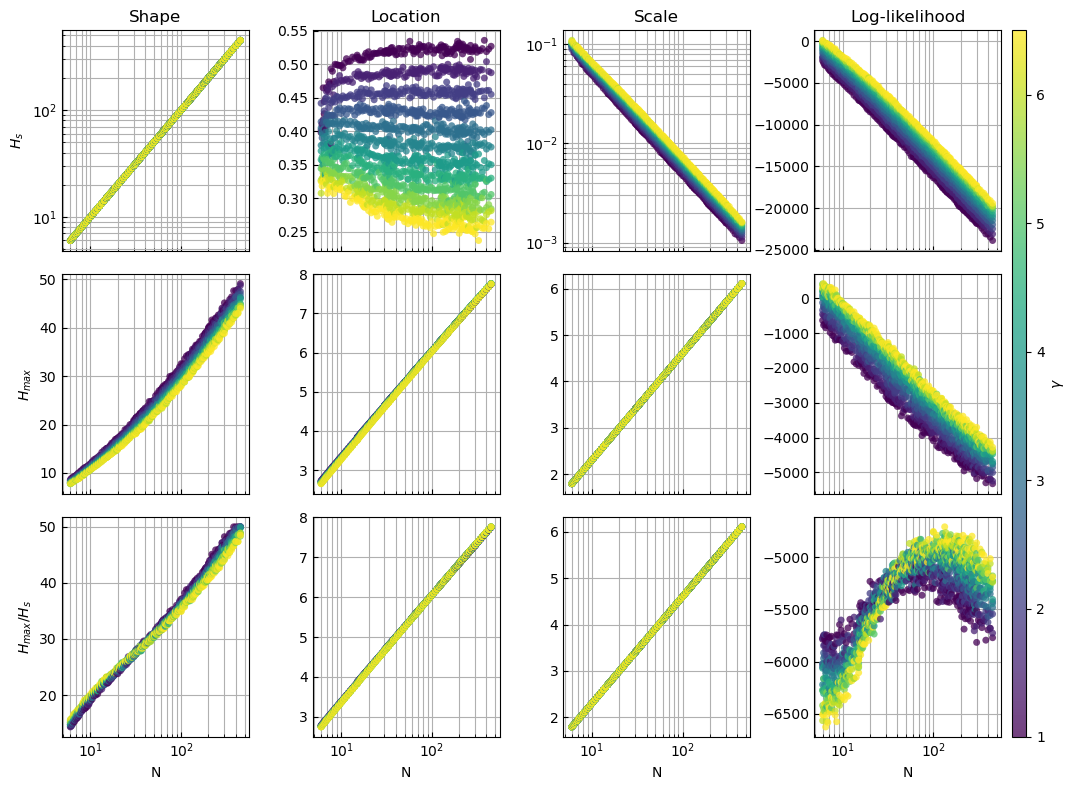

In [5]:
fig,axs = plt.subplots(3,4,figsize=(12,8),sharex=True)
for i,v in enumerate(['Hs','Hmax','HmHs']):
    for p in range(len(dist_fits.param)):
        ax = axs[i,p]
        data = dist_fits.isel(param=p)

        pl=data.plot.scatter(ax=ax,x='N',y=v,hue='gamma',edgecolor='none',alpha=0.75,s=25,add_guide=False,zorder=100)

        ax.set_xscale('log')
        if p in [0,2] and (v == 'Hs'):
            ax.set_yscale('log')
        # if p == 0:
            # ax.set_yscale('log')
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title('')
        ax.tick_params(which='both',direction='in')
        ax.grid(which='both')
        
        if p == 0:
            ax.set_ylabel(labels[v])
        if i == 2:
            ax.set_xlabel('N')

axs[0,0].set_title('Shape')
axs[0,1].set_title('Location')
axs[0,2].set_title('Scale')
axs[0,3].set_title('Log-likelihood')

fig.tight_layout()
cb=fig.colorbar(pl,ax=axs,pad=0.01,aspect=50)
cb.set_label('$\gamma$')
fig.savefig(f'figures/DistributionParameters{suffix}.png',bbox_inches='tight')

# Estimate parametric model for distributions as a function of Gamma and N 

In [6]:
min_N = 10
dist_fits = dist_fits.sel(N=slice(min_N,None))

In [7]:
def summary2xarray(summary2, dim, coord):
    #Convert summary statistics tables output from statsmodel library into xarray to allow saving
    vv1=summary2.tables[0].iloc[:,[0,1]].set_index(0).T.rename(index={1:coord})
    vv2=summary2.tables[0].iloc[:,[2,3]].set_index(2).T.rename(index={3:coord})
    df = pd.concat([vv1,vv2],axis=1)
    for c in df.columns:
        # print(c)
        if c == "Date:":
            df[c] = pd.to_datetime(df[c].astype(str))
        elif c in ['Model:','Dependent Variable:']:
            df[c] = df[c].astype(str).convert_dtypes()
        else:
            df[c] = pd.to_numeric(df[c].astype(str).str.strip())

    ds_stats = xr.Dataset(df).rename({'dim_0':dim})

    # Convert the coefficients table
    ds_fits = xr.Dataset(summary2.tables[1]).rename({'dim_0':'coeff'}).expand_dims({dim:[coord,]})
    
    ds = xr.merge([ds_stats,ds_fits])
    
    # Cleanup variable names not accepted by netcdf
    for v in ds.data_vars:
        ds = ds.rename({v:"".join(i for i in v if i not in r'\/:*?"<>|[]')})

    return ds
    
def get_transform(t):
    if t == 'noop':
        return lambda x:x, ''
    elif t == 'log':
        return np.log, '\log'

def parameter_model(data,ytran='noop',xtran='log',xpow=1.,plot=False,v='',p=''):

    if plot:
        fig,axs = plt.subplot_mosaic('AA\nAA\n01',figsize=(7,8))
    else:
        fig = None

    results = []
    handles = []
    for gamma in data.gamma:
        this_data = data.sel(gamma=gamma)

        xt, xl = get_transform(xtran)
        yt, yl = get_transform(ytran)

        y=yt(this_data.values)
        x=xt(this_data.N.values)**xpow

        if xpow != 1.: 
            xlabel = f'$({xl}N)^{{{xpow}}}$'
        else: 
            xlabel = f'${xl}N$'
        ylabel = f'${yl}{p}$'

        X = sm.add_constant(x)
        ols = sm.OLS(y,X)
        fr = ols.fit()
        results.append(summary2xarray(fr.summary2(),dim='gamma',coord=float(gamma)))
        
        if plot:
            ax = axs['A']
            ax.scatter(x,y,15,alpha=0.5)
            y_hat=ols.predict(fr.params,X)
            ax.plot(x,y_hat,label=float(gamma),alpha=0.75)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)

    ds_regression = xr.merge(results).rename({'coeff':'term'})

    # Finally establish parameter dependance on gamma
    param_results =[] 
    eqn=[]
    for a,t in enumerate(ds_regression.term):
        y = ds_regression['Coef.'].sel(term=t).values
        x = ds_regression['gamma']
        X = x.to_dataframe()
        X['gamma^2'] = X['gamma']**2
        X['Intercept'] = 1
        X = X[['gamma^2','gamma','Intercept']]
        ols = sm.OLS(y,X)
        fr = ols.fit()

        param_results.append(summary2xarray(fr.summary2(),dim='term',coord=str(t.values)))

        fp = fr.params
        e = f'${fp["gamma^2"]:.1E}\gamma^2 + {fp.gamma:.1E}\gamma + {fp.Intercept:.1E}$'
        eqn.append(e)

        if plot:
            ax=axs[str(a)]
            ax.scatter(x,y,alpha=0.5)
            y_hat=ols.predict(fp,X)
            ax.plot(x,y_hat)
            ax.set_xlabel('$\gamma$')
            ax.set_ylabel(t.values)
            ax.set_title(e,fontsize=10)

    eqn = f'{ylabel} = x1.{xlabel} + const'
    
    if plot:
        lax=axs['A'].legend(loc='upper left', bbox_to_anchor=(1.0, 0.95))
        lax.set_title('$\gamma$')
        fig.axes[0].set_title(f'Variable : {labels[v]}, Parameter: ${p}$\n{eqn}')
        fig.tight_layout()
        
    ds_param_model = xr.merge(param_results)

    # Append input transformations to allow recreation    
    for input,value in dict(ytran=ytran,xtran=xtran,xpow=xpow,equation=eqn).items():
        ds_param_model[input]=value
        ds_regression[input]=value

    ds_regression = ds_regression.expand_dims({'variable':[v],'parameter':[p]})
    ds_param_model = ds_param_model.expand_dims({'variable':[v],'parameter':[p]})

    return ds_regression, ds_param_model, fig

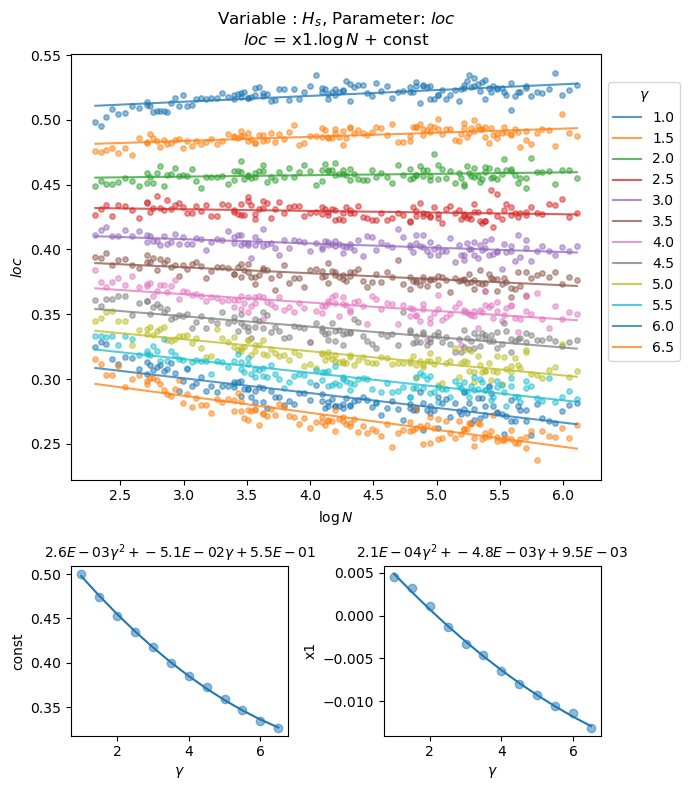

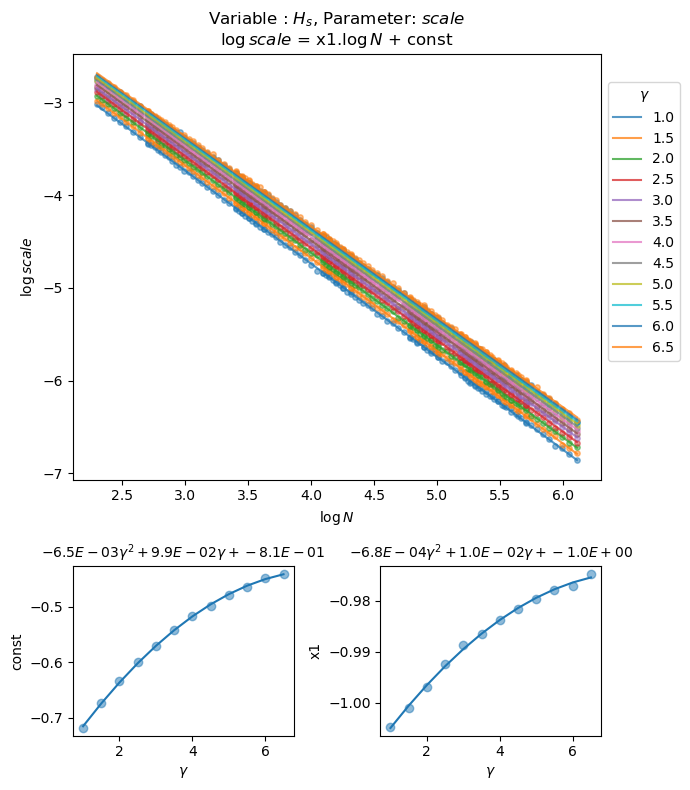

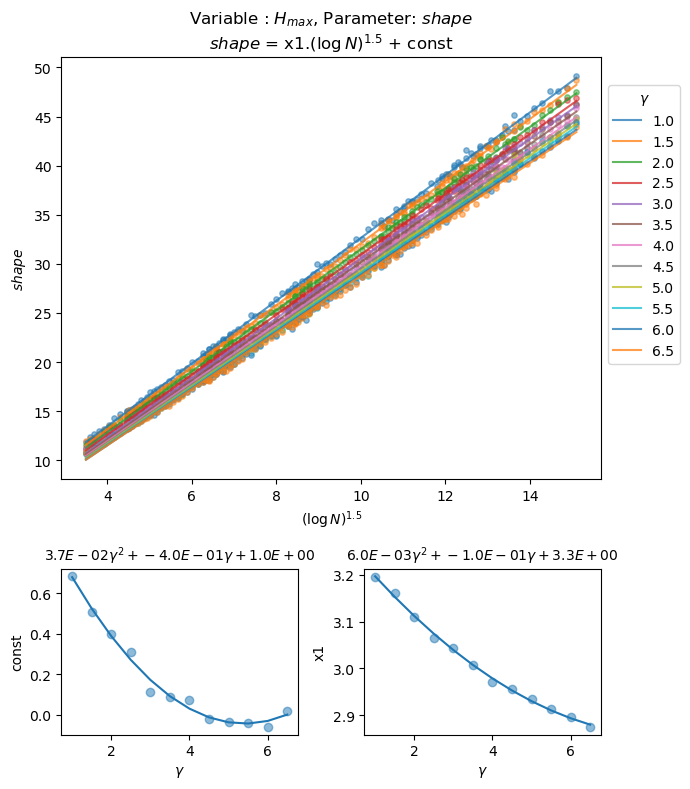

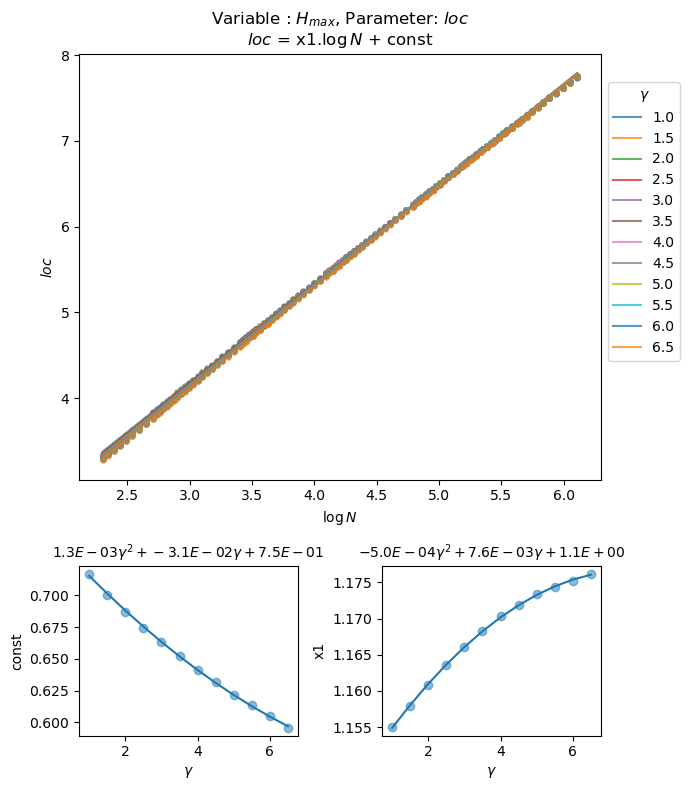

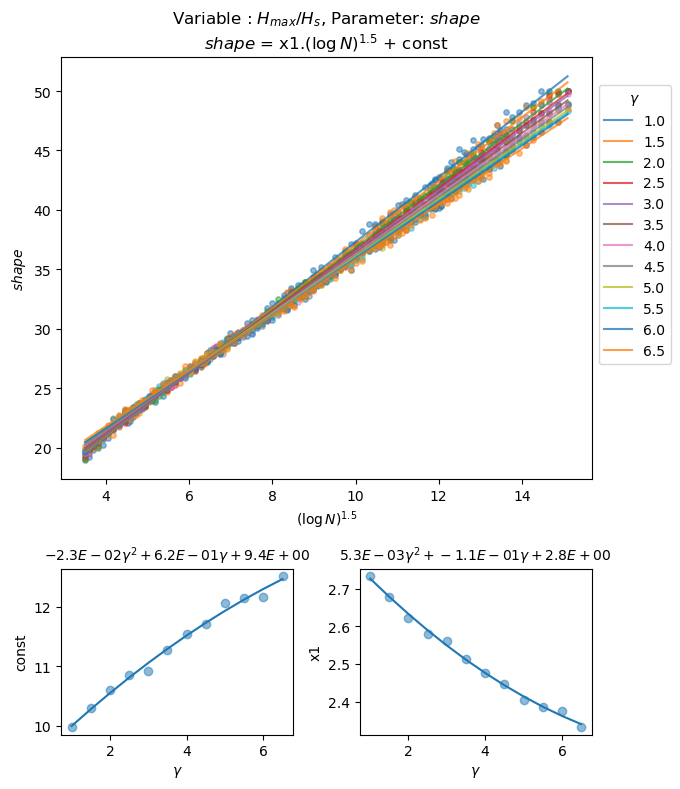

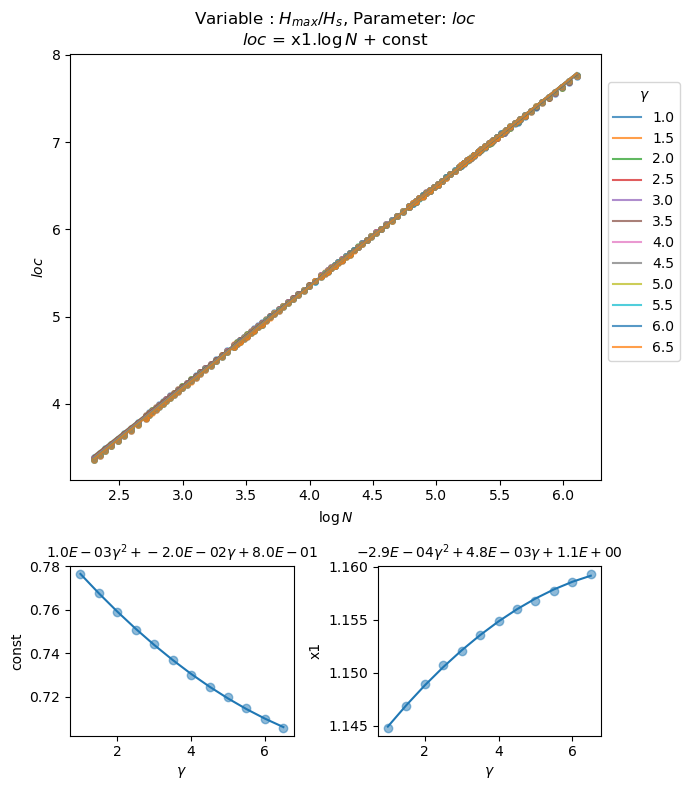

In [8]:
fit_definitions={}
fit_definitions['_DoubleFixed']=[dict(v='Hs', param='loc', transforms=dict(ytran='noop',xtran='log',xpow=1.0)),
                                dict(v='Hs', param='scale', transforms=dict(ytran='log',xtran='log',xpow=1.0)),
                                dict(v='Hmax', param='shape', transforms=dict(ytran='noop',xtran='log',xpow=1.0)),
                                dict(v='Hmax', param='loc', transforms=dict(ytran='noop',xtran='log',xpow=1.0)),
                                dict(v='HmHs', param='shape', transforms=dict(ytran='noop',xtran='log',xpow=1.0)),
                                dict(v='HmHs', param='loc', transforms=dict(ytran='noop',xtran='log',xpow=1.0))]

fit_definitions['_SingleFixed']=[dict(v='Hs', param='loc', transforms=dict(ytran='noop',xtran='log',xpow=1.0)),
                                dict(v='Hs', param='scale', transforms=dict(ytran='log',xtran='log',xpow=1.0)),
                                dict(v='Hmax', param='shape', transforms=dict(ytran='noop',xtran='log',xpow=1.5)),
                                dict(v='Hmax', param='loc', transforms=dict(ytran='noop',xtran='log',xpow=1.0)),
                                dict(v='HmHs', param='shape', transforms=dict(ytran='noop',xtran='log',xpow=1.5)),
                                dict(v='HmHs', param='loc', transforms=dict(ytran='noop',xtran='log',xpow=1.0))]


all_regressions = []
all_parameters = []
fds = fit_definitions[suffix]
for fd in fds:
    v, param, transforms = fd['v'], fd['param'], fd['transforms'] # updates local variables with the dictionary entries
    data = dist_fits[v].sel(param=param)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore') # Silence UserWarning: kurtosistest only valid for n>=20
        ds_regression, ds_param_model, fig = parameter_model(data,plot=True,v=v,p=param,**transforms)
    all_regressions.append(ds_regression)
    all_parameters.append(ds_param_model)
    fig.savefig(f'figures/parameter_regression/fit_{v}_{param}{suffix}.png',bbox_inches='tight')


In [9]:
# Merge results into datasets
ds_regressions = xr.merge(all_regressions)
ds_parameters = xr.merge(all_parameters)

ds_parameters['distribution']=xr.DataArray(['weibull_max','weibull_max','gamma'],dims=['variable',])

# Append on definition of parameters constrained during distribution fits
def append_parameter(ds,v,p,transforms):
    for t,tv in transforms.items():
        ds[t].loc[dict(variable=v,parameter=p)]=tv
    if transforms['xtran'] == 'noop':
        xl = 'N'
    else: 
        xl = '\log(N)'
    eqn = f'${p} = {xl}$'
    ds['equation'].loc[dict(variable=v,parameter=p)]=eqn
    
append_parameter(ds_parameters,v='Hs',p='shape',transforms=dict(ytran='noop',xtran='noop',xpow=1.))
append_parameter(ds_parameters,v='Hmax',p='scale',transforms=dict(ytran='noop',xtran='log',xpow=1.))
append_parameter(ds_parameters,v='HmHs',p='scale',transforms=dict(ytran='noop',xtran='log',xpow=1.))

In [10]:
ds_regressions.to_netcdf(f'data/model/Parameter_Regression{suffix}.nc')
ds_parameters.to_netcdf(f'data/model/Model_Coefficients{suffix}.nc')

In [11]:
ds_parameters

<xarray.Dataset>
Dimensions:             (variable: 3, parameter: 3, term: 2, coeff: 3)
Coordinates:
  * variable            (variable) <U4 'HmHs' 'Hmax' 'Hs'
  * parameter           (parameter) <U5 'loc' 'scale' 'shape'
  * term                (term) object 'const' 'x1'
  * coeff               (coeff) object 'gamma^2' 'gamma' 'Intercept'
Data variables: (12/25)
    Model               (variable, parameter, term) object 'OLS' 'OLS' ... nan
    Dependent Variable  (variable, parameter, term) object 'y' 'y' ... nan nan
    Date                (variable, parameter, term) datetime64[ns] 2022-10-26...
    No. Observations    (variable, parameter, term) float64 12.0 12.0 ... nan
    Df Model            (variable, parameter, term) float64 2.0 2.0 ... nan nan
    Df Residuals        (variable, parameter, term) float64 9.0 9.0 ... nan nan
    ...                  ...
    0.975               (variable, parameter, term, coeff) float64 0.001111 ....
    ytran               (variable, parameter) object 'noop' 'noop' ... 'noop'
    xtran               (variable, parameter) object 'log' 'log' ... 'noop'
    xpow                (variable, parameter) float64 1.0 1.0 1.5 ... 1.0 1.0
    equation            (variable, parameter) object '$loc$ = x1.$\\logN$ + c...
    distribution        (variable) <U11 'weibull_max' 'weibull_max' 'gamma'